In [51]:
import random
import copy
import pickle

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [181]:
# Loading the merged train and test dataset

train_data = pd.read_pickle('advanced_fe_train.pkl')
test_data = pd.read_pickle('advanced_fe_test.pkl')

In [182]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(train_data.shape))
print("\n Test Data Shape : {} \n".format(test_data.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590538, 315) 


 Test Data Shape : (506691, 314) 

*********************************************


In [183]:
train_data

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card5,card6,addr1,addr2,...,uid1_id_02_ct,uid2_id_02_ct,uid1_cents_ct,uid2_cents_ct,uid1_V127_ct,uid2_V127_ct,uid1_V307_ct,uid2_V307_ct,outsider15,isFraud
0,86400,68.50,4,3417,500,42,38,1,166,65,...,0,0,1,1,1,1,1,1,1,0
1,86401,29.00,4,7922,303,42,2,1,173,65,...,1,1,6,6,4,4,1,1,0,0
2,86469,59.00,4,9383,389,42,58,2,178,65,...,0,0,1,1,2,2,2,2,1,0
3,86499,50.00,4,6991,466,42,14,2,282,65,...,2,2,2,2,114,114,115,115,0,0
4,86506,50.00,1,9262,413,42,2,1,241,65,...,1,1,1,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,15811047,49.00,4,10855,500,42,108,2,132,65,...,0,0,2,2,3,3,3,3,1,0
590536,15811049,39.50,4,390,124,42,106,2,78,65,...,0,0,1,1,1,1,1,1,0,0
590537,15811079,30.95,4,1782,494,42,106,2,98,65,...,12,12,8,8,59,59,64,64,0,0
590538,15811088,117.00,4,11847,380,42,106,2,219,65,...,5,5,6,6,24,24,26,26,0,0


In [54]:
# with open("features_having_covariate_shift.pkl", 'rb') as handle:
#   drop_cols = pickle.load(handle)
  
drop_cols = ['D2', 'D11', 'D4', 'D5', 'D15', 'D10', 'D3', 'D1', 'TransactionDay', 'TransactionDT', 'DT_M']

### Utility Functions
<br>

In [55]:
def hyperparam_vs_auc(train_roc_auc, cv_roc_auc):
    
    '''
        Utility Function to plot the Training and Cross Validation ROC-AUC Values
        for different Hyperparameter.
    '''
    
    plt.plot(range(len(train_roc_auc)), train_roc_auc, label='Train AUC')
    plt.plot(range(len(cv_roc_auc)), cv_roc_auc, label='CV AUC')

    plt.scatter(range(len(train_roc_auc)), train_roc_auc, label='Train AUC points')
    plt.scatter(range(len(cv_roc_auc)), cv_roc_auc, label='CV AUC points')
    
    plt.xticks(range(len(train_roc_auc)))
    plt.legend()
    plt.xlabel("Hyperparameter Index")
    plt.ylabel("AUC")
    plt.title("\n Hyperparameter vs ROC-AUC \n")
    plt.grid()
    plt.show()

## Data Preparation
<br>

### Splitting the Dataset
<br>

In [56]:
X_train = train_data.drop(['isFraud']+drop_cols, axis=1)
y_train = train_data['isFraud']

X_test = test_data.drop(drop_cols, axis=1)

del train_data, test_data

In [57]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(X_train.shape))
print("\n Test Data Shape : {} \n".format(X_test.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590538, 303) 


 Test Data Shape : (506691, 303) 

*********************************************


# Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
# 
# dt =  DecisionTreeClassifier(random_state=3, class_weight='balanced')
# dt.fit(X_train, y_train)


from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=3, class_weight='balanced'), param_grid, cv=5, n_jobs=9)
grid_search.fit(X_train, y_train)

dt = grid_search.best_estimator_


In [18]:
grid_search.best_params_

{'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

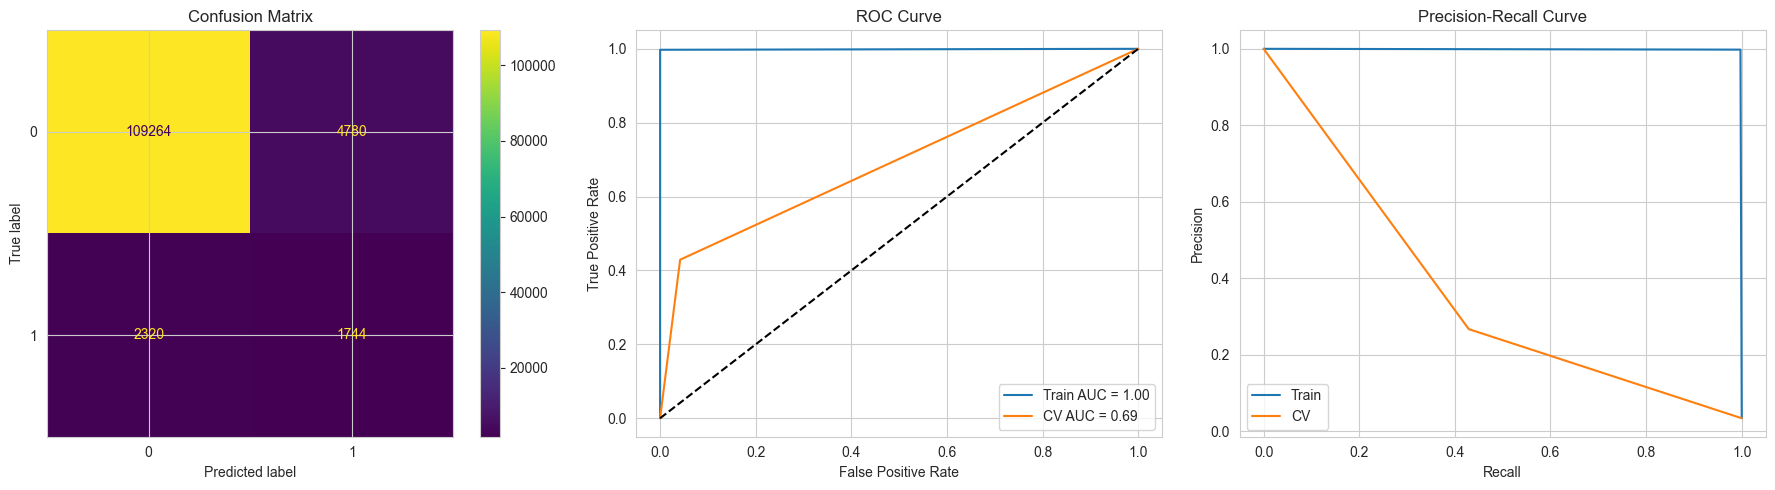

actual    : Counter({0: 114044, 1: 4064})
predicted : Counter({0.0: 111584, 1.0: 6524})
train_auc : 0.9986351306338133
accuracy  : 0.9398855284993396
f1_score  : 0.32942954287873066
precision : 0.2673206621704476
recall    : 0.42913385826771655
cv_auc    : 0.6936101054517707


In [86]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import collections

def classification_metrics_and_plots(model, X_train, y_train, X_cv, y_cv):
    # Predict probabilities
    train_proba = model.predict_proba(X_train)[:, 1]
    cv_proba = model.predict_proba(X_cv)[:, 1]

    # Calculate metrics
    metrics = {}
    metrics["actual"] = collections.Counter(y_cv)
    metrics["predicted"] = collections.Counter(cv_proba)
    metrics['train_auc'] = roc_auc_score(y_train, train_proba)
    metrics['accuracy'] = accuracy_score(y_cv, model.predict(X_cv))
    metrics['f1_score'] = f1_score(y_cv, model.predict(X_cv))
    metrics['precision'] = precision_score(y_cv, model.predict(X_cv))
    metrics['recall'] = recall_score(y_cv, model.predict(X_cv))
    metrics['cv_auc'] = roc_auc_score(y_cv, cv_proba)
    
    # Confusion Matrix
    cm = confusion_matrix(y_cv, model.predict(X_cv))

    # ROC Curve
    train_fpr, train_tpr, _ = roc_curve(y_train, train_proba)
    cv_fpr, cv_tpr, _ = roc_curve(y_cv, cv_proba)

    # PR Curve
    train_precision, train_recall, _ = precision_recall_curve(y_train, train_proba)
    cv_precision, cv_recall, _ = precision_recall_curve(y_cv, cv_proba)

    # Plotting
    plt.figure(figsize=(18, 5))

    # Confusion Matrix
    plt.subplot(1, 3, 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot( ax=plt.gca())
    plt.title('Confusion Matrix')

    # ROC Curve
    plt.subplot(1, 3, 2)
    plt.plot(train_fpr, train_tpr, label=f'Train AUC = {metrics["train_auc"]:.2f}')
    plt.plot(cv_fpr, cv_tpr, label=f'CV AUC = {metrics["cv_auc"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # PR Curve
    plt.subplot(1, 3, 3)
    plt.plot(train_recall, train_precision, label='Train')
    plt.plot(cv_recall, cv_precision, label='CV')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    for k in metrics:
        print(f'{k :10}: {metrics[k]}')
        
    

Example usage:
metrics = classification_metrics_and_plots(dt, X_train1, y_train1, X_cv, y_cv)
print(metrics)
    
X_train1, X_cv, y_train1, y_cv = train_test_split(X_train, y_train, test_size=0.20, shuffle=False)

dt =  DecisionTreeClassifier(random_state=3)
dt.fit(X_train1, y_train1)

train_proba = dt.predict_proba(X_train1)[:, 1]
cv_proba = dt.predict_proba(X_cv)[:, 1]

classification_metrics_and_plots(dt, X_train1, y_train1, X_cv, y_cv)


In [171]:

misclassified_samples


,TransactionAmt,ProductCD,card1,card2,card3,card5,card6,addr1,addr2,dist1,...,uid2_DT_M_ct,uid1_id_02_ct,uid2_id_02_ct,uid1_cents_ct,uid2_cents_ct,uid1_V127_ct,uid2_V127_ct,uid1_V307_ct,uid2_V307_ct,outsider15
472432,33.261,0,13008,3,73,34,2,332,74,NaN,...,6,392,392,285,285,18,18,118,118,0
472434,136.956,0,721,454,73,108,2,332,74,NaN,...,1,1,1,1,1,1,1,1,1,0
472468,49.000,4,13165,220,42,108,2,78,65,NaN,...,6,115,115,15,15,428,431,552,553,0
472504,147.552,0,5276,10,42,108,2,332,74,NaN,...,6,31,31,24,24,5,5,14,14,0
472507,59.636,0,5118,165,73,33,1,332,74,NaN,...,6,62,62,62,62,5,5,18,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590397,16.108,0,10273,307,73,106,2,332,74,NaN,...,6,987,992,511,513,84,84,273,275,0
590445,500.000,1,10436,482,42,108,1,98,65,NaN,...,6,29,29,5,5,21,21,20,20,0
590521,48.877,0,1767,204,4,106,2,332,74,NaN,...,1,12,12,2,2,2,2,12,12,0
590526,250.000,2,1869,73,42,108,1,132,65,NaN,...,3,3,3,1,2,1,1,1,1,0


In [174]:
matched_indices = np.where(y_cv == cv_proba)[0]
matched_samples = X_cv.iloc[matched_indices]

matched_data_orig = pd.concat([matched_samples, y_cv.iloc[matched_indices]], axis=1)

pred_df = pd.DataFrame(cv_proba, columns=['prediction']).squeeze()
pred_df.index = y_cv.index
pred_series_filtered = pred_df.iloc[matched_indices]

matched_data = pd.concat([matched_data_orig, pred_series_filtered], axis=1)
matched_data.columns = list(matched_samples.columns) + ['isFraud', 'prediction']
print(matched_data.columns, matched_samples.shape, matched_data_orig.shape, matched_data.shape)
matched_data

Index(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1',
       ...
       'uid2_id_02_ct', 'uid1_cents_ct', 'uid2_cents_ct', 'uid1_V127_ct',
       'uid2_V127_ct', 'uid1_V307_ct', 'uid2_V307_ct', 'outsider15', 'isFraud',
       'prediction'],
      dtype='object', length=305) (111008, 303) (111008, 304) (111008, 305)


,TransactionAmt,ProductCD,card1,card2,card3,card5,card6,addr1,addr2,dist1,...,uid2_id_02_ct,uid1_cents_ct,uid2_cents_ct,uid1_V127_ct,uid2_V127_ct,uid1_V307_ct,uid2_V307_ct,outsider15,isFraud,prediction
472433,52.811,0,12630,78,4,33,2,332,74,NaN,...,15,11,11,1,1,10,10,0,0,0.0
472435,136.956,0,13265,29,73,34,2,332,74,NaN,...,1270,398,598,53,87,236,430,0,0,0.0
472436,25.000,1,6185,220,42,108,2,162,65,NaN,...,1,1,1,1,1,1,1,0,0,0.0
472437,23.362,0,12812,444,73,33,1,332,74,NaN,...,698,408,409,46,46,225,225,1,0,0.0
472438,326.290,4,10571,454,42,108,2,14,65,3.0,...,0,1,1,2,2,2,2,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,49.000,4,10855,500,42,108,2,132,65,48.0,...,0,2,2,3,3,3,3,1,0,0.0
590536,39.500,4,390,124,42,106,2,78,65,NaN,...,0,1,1,1,1,1,1,0,0,0.0
590537,30.950,4,1782,494,42,106,2,98,65,NaN,...,12,8,8,59,59,64,64,0,0,0.0
590538,117.000,4,11847,380,42,106,2,219,65,3.0,...,5,6,6,24,24,26,26,0,0,0.0


In [172]:
misclassified_indices = np.where(y_cv != cv_proba)[0]
misclassified_samples = X_cv.iloc[misclassified_indices]

missed_data_orig = pd.concat([misclassified_samples, y_cv.iloc[misclassified_indices]], axis=1)

pred_df = pd.DataFrame(cv_proba, columns=['prediction']).squeeze()
pred_df.index = y_cv.index
pred_series_filtered = pred_df.iloc[misclassified_indices]

missed_data = pd.concat([missed_data_orig, pred_series_filtered], axis=1)
missed_data.columns = list(misclassified_samples.columns) + ['isFraud', 'prediction']
print(missed_data.columns, misclassified_samples.shape, missed_data_orig.shape, missed_data.shape)
missed_data

Index(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1',
       ...
       'uid2_id_02_ct', 'uid1_cents_ct', 'uid2_cents_ct', 'uid1_V127_ct',
       'uid2_V127_ct', 'uid1_V307_ct', 'uid2_V307_ct', 'outsider15', 'isFraud',
       'prediction'],
      dtype='object', length=305) (7100, 303) (7100, 304) (7100, 305)


,TransactionAmt,ProductCD,card1,card2,card3,card5,card6,addr1,addr2,dist1,...,uid2_id_02_ct,uid1_cents_ct,uid2_cents_ct,uid1_V127_ct,uid2_V127_ct,uid1_V307_ct,uid2_V307_ct,outsider15,isFraud,prediction
472432,33.261,0,13008,3,73,34,2,332,74,NaN,...,392,285,285,18,18,118,118,0,1,0.0
472434,136.956,0,721,454,73,108,2,332,74,NaN,...,1,1,1,1,1,1,1,0,0,1.0
472468,49.000,4,13165,220,42,108,2,78,65,NaN,...,115,15,15,428,431,552,553,0,1,0.0
472504,147.552,0,5276,10,42,108,2,332,74,NaN,...,31,24,24,5,5,14,14,0,1,0.0
472507,59.636,0,5118,165,73,33,1,332,74,NaN,...,62,62,62,5,5,18,18,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590397,16.108,0,10273,307,73,106,2,332,74,NaN,...,992,511,513,84,84,273,275,0,0,1.0
590445,500.000,1,10436,482,42,108,1,98,65,NaN,...,29,5,5,21,21,20,20,0,0,1.0
590521,48.877,0,1767,204,4,106,2,332,74,NaN,...,12,2,2,2,2,12,12,0,0,1.0
590526,250.000,2,1869,73,42,108,1,132,65,NaN,...,3,1,2,1,1,1,1,0,1,0.0


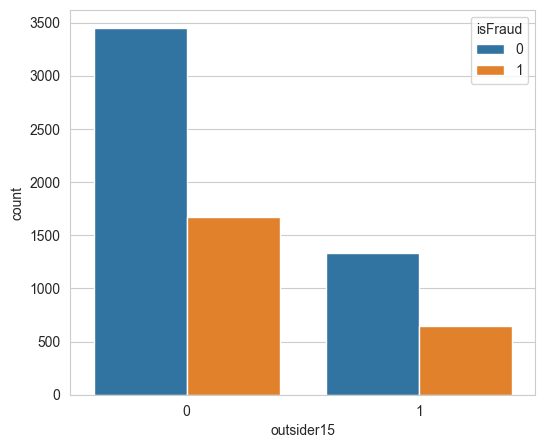

In [173]:
sns.countplot(x='outsider15', hue='isFraud', data=missed_data)
plt.show()

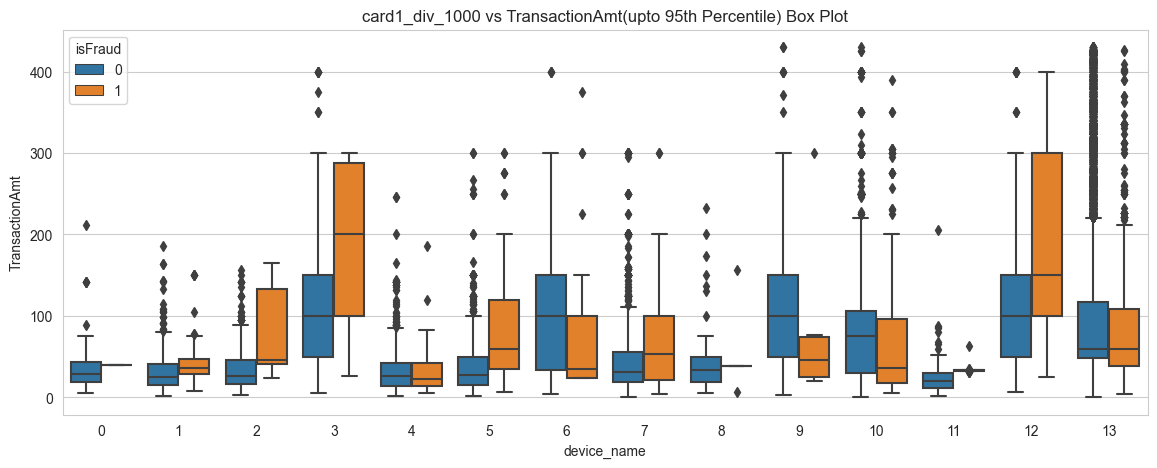

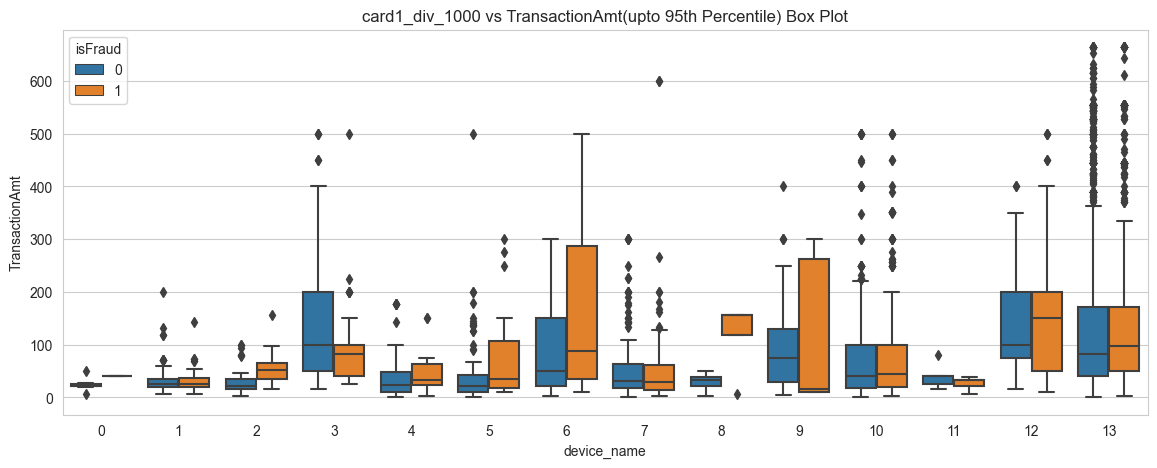

In [179]:
plt.figure(figsize=(14,5))
sns.boxplot(x='device_name', y='TransactionAmt', hue='isFraud', data=matched_data[matched_data['TransactionAmt']<=np.percentile(matched_data['TransactionAmt'], 95)])
plt.title('card1_div_1000 vs TransactionAmt(upto 95th Percentile) Box Plot')
plt.show()

plt.figure(figsize=(14,5))
sns.boxplot(x='device_name', y='TransactionAmt', hue='isFraud', data=missed_data[missed_data['TransactionAmt']<=np.percentile(missed_data['TransactionAmt'], 95)])
plt.title('card1_div_1000 vs TransactionAmt(upto 95th Percentile) Box Plot')
plt.show()

Index(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1',
       ...
       'uid1_id_02_ct', 'uid2_id_02_ct', 'uid1_cents_ct', 'uid2_cents_ct',
       'uid1_V127_ct', 'uid2_V127_ct', 'uid1_V307_ct', 'uid2_V307_ct',
       'outsider15', 'isFraud'],
      dtype='object', length=304)

<br>

## XG Boost Hyperparameter Tuning

<br>

In [11]:
# Hyperparameters

learning_rate = [2e-2, 3e-1, 1e-1]
max_depth = [8, 12, 16]
subsample = [0.6, 0.8, 1]
colsample_bytree = [0.6, 0.8, 1]

In [13]:
results = {}

dtrain = xgb.DMatrix(X_train, label=y_train)

for rate in learning_rate:
  for depth in max_depth:
    for sample in subsample:
      for colsample in colsample_bytree:

        params = {
          'objective' : 'binary:logistic',
          'eval_metric' : 'auc',
          'learning_rate' : rate,
          'max_depth' : depth,
          'subsample' : sample,
          'colsample_bytree' : colsample,
          # 'tree_method' : 'gpu_hist',
          'random_state' : 3,
        }

        history = xgb.cv(
            params,
            dtrain,
            num_boost_round = 3000,
            nfold = 3,
            metrics ='auc',
            early_stopping_rounds = 100,
            verbose_eval=100,
            seed=3,
            shuffle = False
        )

        name = "learning_rate : "+str(rate)+" max_depth : "+str(depth)+" subsample : "+str(sample)+" colsample_bytree : "+str(colsample)
        results[name] = (history.iloc[-1]['train-auc-mean'],history.iloc[-1]['test-auc-mean'])

[0]	train-auc:0.82100+0.00921	test-auc:0.80328+0.00906


KeyboardInterrupt: 

In [2]:
with open ('xgb_cv_results.pkl', 'rb') as handle:
  results = pickle.load(handle)

In [3]:
train_roc_auc = [auc[0] for auc in results.values()]
cv_roc_auc = [auc[1] for auc in results.values()]

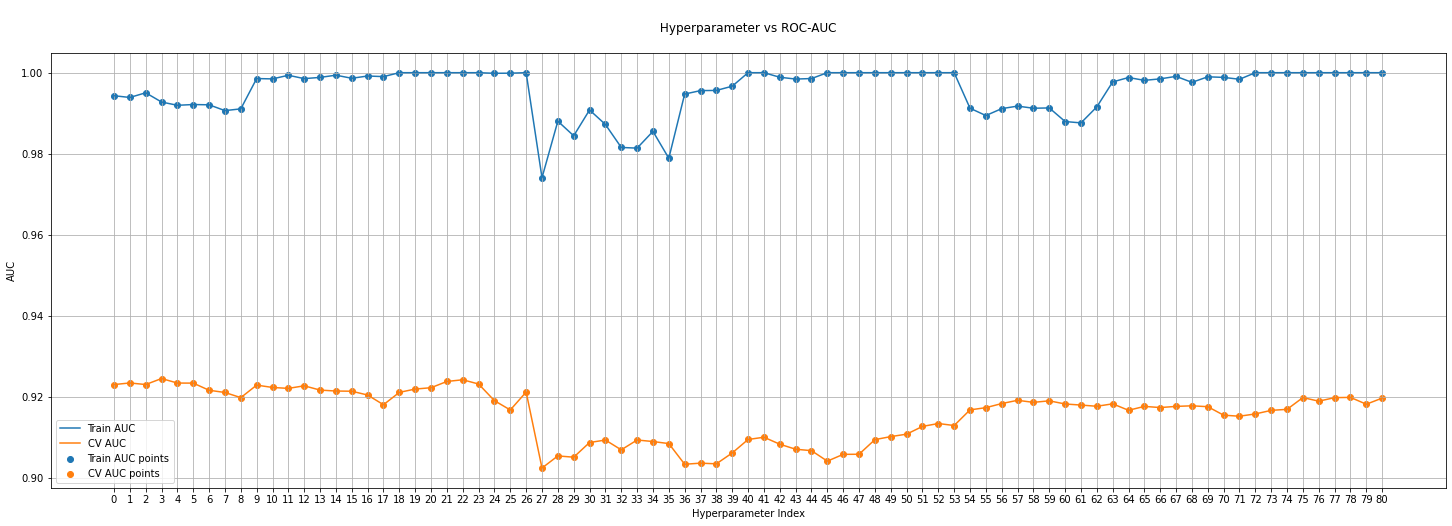

In [6]:
plt.figure(figsize=(25,8))
hyperparam_vs_auc(train_roc_auc, cv_roc_auc)

From the above plot, the best hyperaparameter index is 3.
<br><br>

In [7]:
best_params = list(results.keys())[3]

In [8]:
print("The Best Paramaters are {} ".format(best_params))

The Best Paramaters are learning_rate : 0.02 max_depth : 8 subsample : 0.8 colsample_bytree : 0.6 
